In [ ]:
!git clone https://github.com/DMwr2023/S4Dmodification.git

In [ ]:
# Structured Kernels（restart kernelをしてからもう一回する必要があるかもしれない。その場合だいぶ時間がかかる。逆にだいぶ時間がかかんなかったらうまくいってない）
%cd /workspace/S4Dmodification
# ============= Set Up =============
# Requirements
# 入れなくても動く
# !conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.6 -c pytorch -c nvidia
!pip install -r requirements.txt
# Structured Kernels
%cd extensions/kernels/
!python setup.py install

In [ ]:
!nvcc --version

In [ ]:
# うまくいかなければrestart kernelをする（もしくは上を再実行する）
import importlib
import structured_kernels
importlib.reload(structured_kernels)

In [ ]:
import sys
sys.path.append("/workspace/S4Dmodification/extensions/kernels")
import structured_kernels
print("Structured kernels module loaded successfully.")

In [ ]:
!pip show structured_kernels

In [ ]:
!pip install pybullet

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/structured_kernels-0.1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 7.1 MB/s eta 0:00:00


In [ ]:
%cd /workspace/S4Dmodification

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.kl import kl_divergence
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import time
import argparse

from models.s4.s4 import S4Block as S4  # Can use full version instead of minimal S4D standalone below
from models.s4.s4d import S4D
#from models.s4.s4d import S4D
from tqdm.auto import tqdm
import copy
import gc

from typing import Any, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import gym
import pybullet_envs  # PyBulletの環境をgymに登録する
from einops import rearrange
from torch.utils.tensorboard import SummaryWriter

# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d

INFO:models.s4.s4:CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) found.
/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 環境のWrapper（カメラに関する）

In [ ]:
class GymWrapper_PyBullet(object):
    """
    PyBullet環境のためのラッパー
    """

    metadata = {"render.modes": ["human", "rgb_array"]}
    reward_range = (-np.inf, np.inf)

    # __init__でカメラ位置に関するパラメータ（ cam_dist:カメラ距離，cam_yaw：カメラの水平面での回転，cam_pitch:カメラの縦方向での回転）を受け取り，カメラの位置を調整できるようにします.
    # 　同時に画像の大きさも変更できるようにします
    def __init__(
        self,
        env: gym.Env,
        cam_dist: int = 3,
        cam_yaw: int = 0,
        cam_pitch: int = -30,
        render_width: int = 320,
        render_height: int = 240,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        env : gym.Env
            gymで提供されている環境のインスタンス．
        cam_dist : int
            カメラの距離．
        cam_yaw : int
            カメラの水平面での回転．
        cam_pitch : int
            カメラの縦方向での回転．
        render_width : int
            観測画像の幅．
        render_height : int
            観測画像の高さ．
        """
        self._env = env

        self._render_width = render_width
        self._render_height = render_height
        self._set_nested_attr(self._env, cam_dist, "_cam_dist")
        self._set_nested_attr(self._env, cam_yaw, "_cam_yaw")
        self._set_nested_attr(self._env, cam_pitch, "_cam_pitch")
        self._set_nested_attr(self._env, render_width, "_render_width")
        self._set_nested_attr(self._env, render_height, "_render_height")

    def _set_nested_attr(self, env: gym.Env, value: int, attr: str) -> None:
        """
        多重継承の属性に再帰的にアクセスして値を変更する．
        カメラの設定に利用．

        Parameters
        ----------
        value : int
            設定したい値．
        attr : str
            変更したい属性の名前．
        """
        if hasattr(env, attr):
            setattr(env, attr, value)
        else:
            self._set_nested_attr(env.env, value, attr)

    def __getattr(self, name: str) -> Any:
        """
        環境が保持している属性値を取得するメソッド．

        Parameters
        ----------
        name : str
            取得したい属性値の名前．

        Returns
        -------
        _env.name : Any
            環境が保持している属性値．
        """
        return getattr(self._env, name)

    @property
    def observation_space(self) -> gym.spaces.Box:
        """
        観測空間に関する情報を取得するメソッド．

        Returns
        -------
        space : gym.spaces.Box
            観測空間に関する情報（各画素値の最小値，各画素値の最大値，観測データの形状， データの型）．
        """
        width = self._render_width
        height = self._render_height
        return gym.spaces.Box(0, 255, (height, width, 3), dtype=np.uint8)

    @property
    def action_space(self) -> gym.spaces.Box:
        """
        行動空間に関する情報を取得するメソッド．

        Returns
        -------
        space : gym.spaces.Box
            行動空間に関する情報（各行動の最小値，各行動の最大値，行動空間の次元， データの型） ．
        """
        return self._env.action_space

    # 　元の観測（低次元の状態）は今回は捨てて，env.render()で取得した画像を観測とします.
    #  画像，報酬，終了シグナルが得られます.
    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        """
        環境に行動を与え次の観測，報酬，終了フラグを取得するメソッド．

        Parameters
        ----------
        action : np.dnarray (action_dim, )
            与える行動．

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            行動を与えたときの次の観測．
        reward : float
            行動を与えたときに得られる報酬．
        done : bool
            エピソードが終了したかどうか表すフラグ．
        info : dict
            その他の環境に関する情報．
        """
        _, reward, done, info = self._env.step(action)
        obs = self._env.render(mode="rgb_array") # 今回状態として画像を扱いたいため
        return obs, reward, done, info

    def reset(self) -> np.ndarray:
        """
        環境をリセットするためのメソッド．

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            環境をリセットしたときの初期の観測．
        """
        self._env.reset()
        obs = self._env.render(mode="rgb_array")
        return obs

    def render(self, mode="human", **kwargs) -> np.ndarray:
        """
        観測をレンダリングするためのメソッド．

        Parameters
        ----------
        mode : str
            レンダリング方法に関するオプション． (default='human')

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            観測をレンダリングした結果．
        """
        return self._env.render(mode, **kwargs)

    def close(self) -> None:
        """
        環境を閉じるためのメソッド．
        """
        self._env.close()


#### カメラに関するWrapperのテスト

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require 

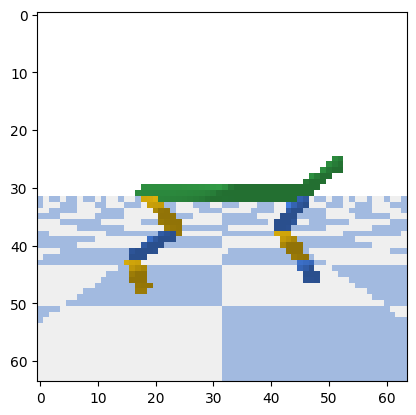

In [ ]:
env = gym.make("HalfCheetahBulletEnv-v0")
# カメラのパラメータを与えてカメラの位置と角度，画像の大きさを調整
env = GymWrapper_PyBullet(
    env, cam_dist=2, cam_pitch=0, render_width=64, render_height=64
)

env.reset()
image = env.render(mode="rgb_array")
plt.imshow(image)
plt.show()
env.close()
del env

### 環境のWrapper（行動の連続入力に関する）

In [ ]:
class RepeatAction(gym.Wrapper):
    """
    同じ行動を指定された回数自動的に繰り返すラッパー．観測は最後の行動に対応するものになる
    """

    def __init__(self, env: GymWrapper_PyBullet, skip: int = 4) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        env : GymWrapper_PyBullet
            環境のインスタンス．今回は先程定義したラッパーでラップした環境を利用する．
        skip : int
            同じ行動を繰り返す回数．
        """
        gym.Wrapper.__init__(self, env)
        self._skip = skip

    def reset(self) -> np.ndarray:
        """
        環境をリセットするためのメソッド．

        Returns
        -------
        obs : np.ndarray (width, height, 3)
            環境をリセットしたときの初期の観測．
        """
        return self.env.reset()

    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        """
        環境に行動を与え次の観測，報酬，終了フラグを取得するメソッド．
        与えられた行動をskipの回数だけ繰り返した結果を返す．

        Parameters
        ----------
        action : np.ndarray (action_dim, )
            与える行動．

        Returns
        -------
        obs : np.ndarray (width, height, 3)
            行動をskipの回数だけ繰り返したあとの観測．
        total_reawrd : float
            行動をskipの回数だけ繰り返したときの報酬和．
        done : bool
            エピソードが終了したかどうか表すフラグ．
        info : dict
            その他の環境に関する情報．
        """
        total_reward = 0.0
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

#### Wrapperを通した環境を作る関数

In [ ]:
def make_env() -> RepeatAction:
    """
    作成たラッパーをまとめて適用して環境を作成する関数．

    Returns
    -------
    env : RepeatAction
        ラッパーを適用した環境．
    """
    env = gym.make("HalfCheetahBulletEnv-v0")  # 環境を読み込む．今回はHalfCheetah
    # Dreamerでは観測は64x64のRGB画像
    env = GymWrapper_PyBullet(
        env, cam_dist=2, cam_pitch=0, render_width=64, render_height=64
    )
    env = RepeatAction(env, skip=2)  # DreamerではActionRepeatは2
    return env

### Replay Buffer
連続した経験をとってくるのでDQNとは少し違う

In [ ]:
# 　今回のReplayBuffer
class ReplayBuffer(object):
    """
    RNNを用いて訓練するのに適したリプレイバッファ．
    """

    def __init__(
        self, capacity: int, observation_shape: List[int], action_dim: int
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        capacity : int
            リプレイバッファにためておくことができる経験の上限．
        observation_shape : List[int]
            環境から与えられる観測の形状．
        action_dim : int
            行動空間の次元数．
        """

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.uint8)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=bool)
        # self.done = np.zeros((capacity, 1), dtype=np.bool)

        self.index = 0
        self.is_filled = False
        self.capacity = capacity

    def push(
        self, observation: np.ndarray, action: np.ndarray, reward: float, done: bool
    ) -> None:
        """
        リプレイバッファに経験を追加するメソッド．

        Parameters
        ----------
        observation : np.ndarray (64, 64, 3)
            環境から得られた観測．
        action : np.ndarray (action_dim, )
            エージェントがとった（もしくは経験を貯める際のランダムな）行動．
        reward : float
            観測に対して行動をとったときに得られる報酬．
        done : bool
            エピソードが終了するかどうかのフラグ．
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done

        # indexは巡回し，最も古い経験を上書きする
        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size: int, chunk_length: int) -> Tuple[np.ndarray]:
        """
        経験をリプレイバッファからサンプルします．（ほぼ）一様なサンプルです．
        結果として返ってくるのは観測（画像），行動，報酬，終了シグナルについての(batch_size, chunk_length, 各要素の次元)の配列です．
        各バッチは連続した経験になっています．
        注意: chunk_lengthをあまり大きな値にすると問題が発生する場合があります．

        Parameters
        ----------
        batch_size : int
            バッチサイズ．
        chunk_length : int
            バッチあたりの系列長．


        Returns
        -------
        sampled_observations : np.ndarray (batch size, chunk length, 3, 64, 64)
            バッファからサンプリングされた観測．
        sampled_actions : np.ndarray (batch size, chunk length, action dim)
            バッファからサンプリングされた行動．
        sampled_rewards : np.ndarray (batch size, chunk length, 1)
            バッファからサンプリングされた報酬．
        sampled_done : np.ndarray (batch size, chunk length, 1)
            バッファからサンプリングされたエピソードの終了フラグ．
        """
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1)
                final_index = initial_index + chunk_length - 1
                cross_border = np.logical_and(
                    initial_index <= episode_borders, episode_borders < final_index
                ).any()  # 論理積
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations.shape[1:]
        )
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, chunk_length, self.actions.shape[1]
        )
        sampled_rewards = self.rewards[sampled_indexes].reshape(
            batch_size, chunk_length, 1
        )
        sampled_done = self.done[sampled_indexes].reshape(batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_done

    def __len__(self) -> int:
        """
        バッファに貯められている経験の数を返すメソッド．

        Returns
        -------
        length : int
            バッファに貯められている経験の数．
        """
        return self.capacity if self.is_filled else self.index

#### 観測の前処理を行う関数
ラッパーとして最初から適用してしまわないのは，リプレイバッファにはより容量の小さなnp．uint8の形式で保存しておきたいためです．

In [ ]:
def preprocess_obs(obs: np.ndarray) -> np.ndarray:
    """
    画像を正規化する．[0, 255] -> [-0.5, 0.5]．

    Parameters
    ----------
    obs : np.ndarray (64, 64, 3) or (chank length, batch size, 64, 64, 3)
        環境から得られた観測．画素値は[0, 255]．

    Returns
    -------
    normalized_obs : np.ndarray (64, 64, 3) or (chank length, batch size, 64, 64, 3)
        画素値を[-0.5, 0.5]で正規化した観測．
    """
    obs = obs.astype(np.float32)
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs

#### λ-returnを計算する関数

In [ ]:
def lambda_target(
    rewards: torch.Tensor, values: torch.Tensor, gamma: float, lambda_: float
) -> torch.Tensor:
    """
    価値関数の学習のためのλ-returnを計算する関数．

    Parameters
    ----------
    rewards : torch.Tensor (imagination_horizon, batch size * (chank length - 1))
        報酬モデルによる報酬の推定値．
    values : torch.Tensor (imagination_horizon, batch size * (chank length - 1))
        価値関数を近似するValueモデルによる状態価値観数の推定値．
    gamma : float
        割引率．
    lambda_ : float
        λ-returnのパラメータλ．

    V_lambda : torch.Tensor (imagination_horizon, batch size * (chank length - 1))
        各状態に対するλ-returnの値．
    """
    V_lambda = torch.zeros_like(rewards, device=rewards.device)

    H = rewards.shape[0] - 1
    V_n = torch.zeros_like(rewards, device=rewards.device)
    V_n[H] = values[H]
    for n in range(1, H + 1):
        # まずn-step returnを計算します
        # 注意: 系列が途中で終わってしまったら，可能な中で最大のnを用いたn-stepを使います
        V_n[:-n] = (gamma**n) * values[n:]
        for k in range(1, n + 1):
            if k == n:
                V_n[:-n] += (gamma ** (n - 1)) * rewards[k:]
            else:
                V_n[:-n] += (gamma ** (k - 1)) * rewards[k : -n + k]

        # lambda_でn-step returnを重みづけてλ-returnを計算します
        if n == H:
            V_lambda += (lambda_ ** (H - 1)) * V_n
        else:
            V_lambda += (1 - lambda_) * (lambda_ ** (n - 1)) * V_n

    return V_lambda

## ここからはモデルの実装編

### S4Block (p26 Figure21参照)

In [ ]:
class S4Block(nn.Module):

    def __init__(
        self,
        d_model=256,
        d_mlp = 512,
        n_layers=2,
        dropout=0.2,
        prenorm=True,
        lr=0.001,
        dropout_fn=nn.Dropout
    ):
        super(S4Block, self).__init__()

        self.prenorm = prenorm

        # Stack S4 layers as residual blocks
        self.norms = nn.ModuleList()
        self.s4_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.norms.append(nn.LayerNorm(d_model))
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, lr))
            )
            self.dropouts.append(dropout_fn(dropout))

        self.norm_mlp = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_mlp),
            nn.GELU(),
            dropout_fn(dropout),
            nn.Linear(d_mlp, d_model),
            dropout_fn(dropout))

    def forward(self, x):
        """
        Input x is shape (B, L, d_model), L is the length of continuous observations, B is the batch size
        """
        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for norm, s4, dropout in \
            zip(self.norms, self.s4_layers, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x #z.shape=torch.Size([8, 512, 100])
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # Apply S4 block: we ignore the state input and output
            z, _ = s4(z)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)

        #TODO: x_にも操作が反映されてたりしないか確認する. residual connectionのため
        x_ = x
        x = x_ + self.norm_mlp(x)

        return x

    def imagine(self, x, S4hidden):
        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        # assert x.size(1) == 1 and S4hidden.size(1) == 1 d_model 1になるか？要確認
        for norm, s4, dropout in \
            zip(self.norms, self.s4_layers, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # print("z(B, H(d_model), L)", z.shape)
            # print("S4hidden(B, H(d_model), L)", S4hidden.shape)

            # Apply S4 block: y, x_kを出力
            # A_bar.shape, A_bar.dtype=torch.Size([512, 32]) torch.complex64
            # B_bar.shape, B_bar.dtype=torch.Size([512, 32]) torch.complex64
            # C.shape=torch.Size([512, 32])
            # D.shape=torch.Size([512])
            z, S4hidden_next = s4.generate(z, S4hidden)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)

        #TODO: x_にも操作が反映されてたりしないか確認する. residual connectionのため
        x_ = x
        x = x_ + self.norm_mlp(x)

        return x, S4hidden_next

### HistoryEncoder
HistoryEncoderはPriorに当たる<br>
(次元を表す変数が"*\_dim"だったり"d\_\*"だったりして紛らわしかもしれません)

In [ ]:
class HistoryEncoder(nn.Module):

    def __init__(
        self,

        z_dim, # z_dim=1024にする予定. Encoderからの出力zの次元と合わせる必要がある
        action_dim,
        gMLP_dim=512,

        history_dim=512,
        S4_mlp_dim=512,
        S4_n_layers=8,
        dropout=0.2,
        prenorm=True,

        zMLP_dim=512,
        class_size=32,
        category_size=32,
        lr=0.001,
    ):
        super(HistoryEncoder, self).__init__()
        self.class_size = class_size
        self.category_size = category_size
        self.gMLP = nn.Sequential(
            nn.Linear(z_dim + action_dim, gMLP_dim),
            nn.ReLU(),
            nn.Linear(gMLP_dim, history_dim)
        )

        self.S4s = nn.ModuleList(
            [S4Block(d_model=history_dim, d_mlp=S4_mlp_dim, n_layers=2, dropout=dropout, prenorm=prenorm, lr=lr) for _ in range(S4_n_layers)]
            )

        self.zMLP = nn.Sequential(
            nn.Linear(history_dim, zMLP_dim),
            nn.ReLU(),
            nn.Linear(zMLP_dim, z_dim)
        )

    def forward(self, z, action):
        """
        Parameters
        ----------
        z : torch.Tensor (batch_size, L, z_dim)
            環境から得られた観測画像の潜在表現. この時点ではone-hot vectorである

        action : torch.Tensor (batch_size, L, action_dim)

        Returns
        ----------
        h : torch.Tensor (batch_size, L, history_dim)
            観測画像を埋め込み、カテゴリカル分布からサンプルしたもの(この時点ではone-hot vector)
            勾配を通してあるのはreward lossからの勾配を計算するため

        z : torch.Tensor (batch_size, L, z_dim)
            次の環境の観測画像の潜在表現. この時点ではone-hot vectorである

        dist: torch.distribution
            zの分布.ELBOのKL-divergenceを計算するために必要. (B, L-1, category_size, class_size)の形の分布となる

        dist_no_grad: torch.distribution
            zの分布.ELBOのKL-divergenceを計算するために必要
        """
        g = self.gMLP(torch.cat([z, action], dim=-1))
        for S4 in self.S4s:
            g = S4(g) # 最終的にhが出力される
        h = g
        logits = self.zMLP(h).reshape(*h.shape[:-1], self.category_size, self.class_size) # (batch_size, L, z_dim) -> (batch_size, L, category_dim, class_dim)
        probs = torch.softmax(logits, dim=-1) * 0.99 + (0.01 / self.class_size)
        one_hot_dist = torch.distributions.OneHotCategorical(probs=probs)
        if z.size(1) > 1:
            dist = torch.distributions.OneHotCategorical(probs=probs[:, :-1, :, :])
            dist_no_grad = torch.distributions.OneHotCategorical(probs=probs[:, :-1, :, :].detach())
        else:
            dist, dist_no_grad = None, None
        stoch = one_hot_dist.sample()
        stoch += probs - probs.detach() # using "straight-through gradients"
        z = torch.flatten(stoch, start_dim=-2, end_dim=-1)

        return h, z, dist, dist_no_grad


    def imagine(self, z, action, S4_hiddens=None):
        # S4_hiddens is list of S4_hidden
        g = self.gMLP(torch.cat([z, action], dim=-1))
        if S4_hiddens is None:
            S4_hidden = torch.zeros(512, 32, dtype=torch.complex64)  #初期隠れ状態として1×1×H×N//2のゼロ行列を作る（history_dim×64//2）
            S4_hidden = S4_hidden.reshape(1, 1, 1, *S4_hidden.shape) #リストから取り出すと0次元目が消えるので
            S4_hiddens = list(S4_hidden.to(device))
        S4_hiddens_next = []
        for S4, S4_hidden in zip(self.S4s, S4_hiddens):
            g, S4_hidden_next = S4.imagine(g, S4_hidden) # 最終的にhが出力される S4_hiddenがx_k-1
            S4_hiddens_next.append(S4_hidden_next)
        h = g
        logits = self.zMLP(h).reshape(*h.shape[:-1], self.category_size, self.class_size) # (batch_size, L, z_dim) -> (batch_size, L, category_dim, class_dim)
        probs = torch.softmax(logits, dim=-1) * 0.99 + (0.01 / self.class_size)
        one_hot_dist = torch.distributions.OneHotCategorical(probs=probs)
        stoch = one_hot_dist.sample()
        stoch += probs - probs.detach() # using "straight-through gradients"
        z = torch.flatten(stoch, start_dim=-2, end_dim=-1)

        return h, z, S4_hiddens_next

    def deter(self, z, action):
        with torch.no_grad():
            g = self.gMLP(torch.cat([z, action], dim=-1))
            for S4 in self.S4s:
                g = self.S4(g) # 最終的にhが出力される
            h = g
            logits = self.zMLP(h).reshape(*h.shape[:-1], self.category_size, self.class_size) # (batch_size, L, z_dim) -> (batch_size, L, category_dim, class_dim)

        max_indices = torch.argmax(logits, dim=-1)
        one_hot = F.one_hot(max_indices, num_classes=logits.size(-1))
        one_hot = one_hot.reshape(*one_hot.shape[:1], -1)
        assert one_hot.size(-1) == self.category_size * self.class_size
        return one_hot

### Encoder, Decoder
EncoderはPosteriorに当たる<br>
(Decodeで画像にする必要はあるか？評価する上では画像にする必要はありそうだけど実際にモデルとしては軽いほうがいい)

In [ ]:
class Encoder(nn.Module):
    """
    (input_dim, 64, 64)の画像を(1024,)のベクトルに変換する
    """

    def __init__(
        self,
        input_dim=3, # grayscaleなら1
        category_size=32,
        class_size=32,
    ):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.cv1 = nn.Conv2d(input_dim, 32, kernel_size=4, stride=2) # (input_dim, 64, 64) -> (32, 31, 31)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # (32, 31, 31) -> (64, 14, 14)
        self.cv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2) # (64, 14, 14) -> (128, 6, 6)
        self.cv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2) # (128, 6, 6) -> (256, 2, 2)
        self.category_size = category_size
        self.class_size = class_size

    def forward(self, obs):
        """
        Parameters
        ----------
        obs : torch.Tensor (batch_size, L, input_dim, 64, 64), Lは連続した観測画像の系列長
            環境から得られた観測画像

        Returns
        ----------
        z : torch.Tensor (batch_size, L, z_dim)
            観測画像を埋め込み、カテゴリカル分布からサンプルしたもの(この時点ではone-hot vector)
            勾配を通してあるのはreward lossからの勾配を計算するため

        dist: torch.distribution
            zの分布.ELBOのKL-divergenceを計算するために必要. (B, L-1, category_size, class_size)の形の分布となる

        dist_no_grad: torch.distribution
            zの分布.ELBOのKL-divergenceを計算するために必要
        """
        B, L = obs.shape[:2]
        hidden = F.silu(self.cv1(obs.reshape(B*L, *obs.shape[2:])))
        hidden = F.silu(self.cv2(hidden))
        hidden = F.silu(self.cv3(hidden))
        hidden = F.silu(self.cv4(hidden))
        # チャネルのハイパラがあっているかチェック
        assert hidden.size(-3) * hidden.size(-2) * hidden.size(-1) == self.category_size * self.class_size
        logits = hidden.reshape(B, L, self.category_size, self.class_size) # (B*L, 256, 2, 2) -> (B, L, category_size, class_size)
        probs = torch.softmax(logits, dim=-1) * 0.99 + (0.01 / self.class_size)
        one_hot_dist = torch.distributions.OneHotCategorical(probs=probs)
        if L > 1:
            dist = torch.distributions.OneHotCategorical(probs=probs[:, 1:, :, :])
            dist_no_grad = torch.distributions.OneHotCategorical(probs=probs[:, 1:, :, :].detach())
        else:
            dist, dist_no_grad = None, None
        stoch = one_hot_dist.sample()
        stoch += probs - probs.detach() # using "straight-through gradients"
        z = torch.flatten(stoch, start_dim=-2, end_dim=-1)
        assert z.size(-1) == self.category_size * self.class_size

        return z, dist, dist_no_grad



class Decoder(nn.Module):
    """
    (z_dim + hidtory_dim,)のベクトルを(input_dim, 64, 64)の画像に変換する
    """

    def __init__(
        self,
        output_dim=3, # grayscaleなら1
        z_dim=1024,
        history_dim=1024,
    ):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.fc = nn.Linear(z_dim + history_dim, 1024)
        self.cv1 = nn.ConvTranspose2d(1024, 128, kernel_size=5, stride=2) # (1024, 1, 1) -> (128, 5, 5)
        self.cv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2) # (128, 5, 5) -> (64, 13, 13)
        self.cv3 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2) # (64, 13, 13) -> (32, 30, 30)
        self.cv4 = nn.ConvTranspose2d(32, output_dim, kernel_size=6, stride=2) # (32, 30, 30) -> (input_dim, 64, 64)

    def forward(self, h, z):
        """
        Parameters
        ----------
        h: torch.Tensor (batch_size, L, history_dim)
            これまでの履歴(S4Blockからの出力)

        z : torch.Tensor (batch_size, L, z_dim)
            次の観測の潜在表現

        Returns
        ----------
        obs : torch.Tensor (batch_size, L, output_dim, 64, 64)
            次の観測画像
        """
        B, L = h.shape[:2]
        hidden = self.fc(torch.cat([z, h], dim=-1))
        hidden = hidden.reshape(B*L, 1024, 1, 1)
        hidden = F.silu(self.cv1(hidden))
        hidden = F.silu(self.cv2(hidden))
        hidden = F.silu(self.cv3(hidden))
        obs = self.cv4(hidden)

        return obs.reshape(B, L, *obs.shape[-3:])


### RewardModel
報酬モデル. 1層のMLP

In [ ]:
class RewardModel(nn.Module):

    def __init__(
        self,
        history_dim,
        z_dim,
        mlp_dim=512,
    ):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(history_dim + z_dim, mlp_dim),
            nn.SiLU(),
            nn.Linear(mlp_dim, 1)
        )

    def forward(self, h, z):
        """
        Parameters
        ----------
        h: torch.Tensor (batch_size, L, history_dim)
            これまでの履歴

        z : torch.Tensor (batch_size, L, z_dim)
            次の観測の潜在表現

        Returns
        ----------
        reward : torch.Tensor (batch_size, L, 1)
            報酬の予測値
        """
        reward = self.fc1(torch.cat([h, z], dim=-1))

        return reward


### PolicyModel
まだ実装しない（世界モデルのみをテストしてから）

In [ ]:
class PolicyModel(nn.Module):
    def __init__(
            self,
            z_dim,
            history_dim,
            action_dim,
            mlp_dim=512,
            min_std = 0.01
        ):
        super(PolicyModel, self).__init__()
        self.min_std = min_std

        self.fc1 = nn.Linear(history_dim + z_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, mlp_dim)
        self.fc3 = nn.Linear(mlp_dim, mlp_dim)
        self.fc4 = nn.Linear(mlp_dim, mlp_dim)
        self.fc_mean = nn.Linear(mlp_dim, action_dim)
        self.fc_stddev = nn.Linear(mlp_dim, action_dim)

    def forward(self, h, z):
        hidden = F.silu(self.fc1(torch.cat([h, z], dim=-1)))
        hidden = F.silu(self.fc2(hidden))
        hidden = F.silu(self.fc3(hidden))
        hidden = F.silu(self.fc4(hidden))
        mean = torch.tanh(self.fc_mean(hidden))
        std = self.fc_stddev(hidden)
        std = F.softplus(std) + self.min_std

        eps = (torch.rand_like(mean) - 0.5) * 2
        action = mean + eps * std

        return action

    def deter(self, h, z):
        hidden = F.silu(self.fc1(torch.cat([h, z], dim=-1)))
        hidden = F.silu(self.fc2(hidden))
        hidden = F.silu(self.fc3(hidden))
        hidden = F.silu(self.fc4(hidden))
        mean = torch.tanh(self.fc_mean(hidden))

        return mean

### ValueModel
まだ実装しない（世界モデルのみをテストしてから）

In [ ]:
class ValueModel(nn.Module):
    def __init__(self, z_dim, history_dim, mlp_dim=512):
        super(ValueModel, self).__init__()

        self.fc1 = nn.Linear(history_dim + z_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, mlp_dim)
        self.fc3 = nn.Linear(mlp_dim, mlp_dim)
        self.fc4 = nn.Linear(mlp_dim, 1)

    def forward(self, h, z):
        hidden = F.silu(self.fc1(torch.cat([h, z], dim=-1)))
        hidden = F.silu(self.fc2(hidden))
        hidden = F.silu(self.fc3(hidden))
        value = self.fc4(hidden)
        return value

## 学習の実装編

### 学習の実装（世界モデルのみテストする）

In [ ]:
#最初の数エピソードはランダムに行動して経験をリプレイバッファに集める
env = make_env()
buffer_capacity = 200000
replay_buffer = ReplayBuffer(capacity=buffer_capacity, observation_shape=env.observation_space.shape, action_dim=env.action_space.shape[0])
seed_episode=50
for _ in range(seed_episode):
    obs = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        replay_buffer.push(obs, action, reward, done)
        obs = next_obs
del env
gc.collect()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


3396

In [ ]:
# 可視化のためにTensorBoardを用いるので，Colab上でTensorBoardを表示するための宣言を行う
%cd /workspace/assets
#学習結果を確認するためにTensorBoardを立ち上げておく
log_dir = "logs"
writer = SummaryWriter(log_dir)

[Errno 2] No such file or directory: '/workspace/assets'
/content/drive/MyDrive/Colab Notebooks/WorldModel2024/最終課題/S4Dmodification


#### オプティマイザのセットアップ関数
S4は重み減衰から外します

In [ ]:
from timm.scheduler.cosine_lr import CosineLRScheduler
def setup_optimizer(model_params, lr, weight_decay, epochs):
    """
    S4 requires a specific optimizer setup.

    The S4 layer (A, B, C, dt) parameters typically
    require a smaller learning rate (typically 0.001), with no weight decay.

    The rest of the model can be trained with a higher learning rate (e.g. 0.004, 0.01)
    and weight decay (if desired).
    """

    # General parameters don't contain the special _optim key
    params = [p for p in model_params if not hasattr(p, "_optim")]

    # Create an optimizer with the general parameters
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    # Add parameters with special hyperparameters
    hps = [getattr(p, "_optim") for p in model_params if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in model_params if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    # Create a lr scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.2)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs+20)
    # We use a linear warmup (1000 gradient steps) and cosine anneal learning rate schedule for S4WM.なので
    scheduler = CosineLRScheduler(optimizer, t_initial=1000, lr_min=1e-3, warmup_t=1000, warmup_lr_init=1e-4, warmup_prefix=True)

    # Print optimizer info
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler


#### 学習ループ

In [ ]:
# Training Loop

env = make_env()
# Hyperparameters
grayscale = False
category_size = 32
class_size = 32
z_dim = category_size * class_size
history_dim = 512
gMLP_dim = 1000
S4_mlp_dim = 2048
zMLP_dim = 1000
dropout = 0.2
rewardMLP_dim = 1024
alpha = 0.8
beta_recon = 1.0
beta_rew = 35.0
beta_kl = 10.0
free_bits = 1.0
model_lr = 1e-3
weight_decay = 1e-2



start_epoch = 0
restart_training = False

if not restart_training:
    encoder = Encoder(
        input_dim=(1 if grayscale else 3),
        category_size=category_size,
        class_size=class_size
    ).to(device)

    decoder = Decoder(
        output_dim=(1 if grayscale else 3),
        z_dim=z_dim,
        history_dim=history_dim
    ).to(device)

    historyEncoder = HistoryEncoder(
        z_dim=z_dim,
        action_dim=env.action_space.shape[0],
        gMLP_dim=gMLP_dim,
        history_dim=history_dim,
        S4_mlp_dim=S4_mlp_dim,
        S4_n_layers=6,
        dropout=dropout,
        prenorm=True,
        zMLP_dim=zMLP_dim,
        class_size=class_size,
        category_size=category_size,
        lr=model_lr
    ).to(device)

    rewardModel = RewardModel(
        history_dim=history_dim,
        z_dim=z_dim,
        mlp_dim=rewardMLP_dim
    ).to(device)

EPOCHS = 1000
# 世界モデルのパラメータたち
model_params = (list(encoder.parameters()) + list(decoder.parameters())  + list(historyEncoder.parameters()) + list(rewardModel.parameters()))

model_optimizer, scheduler = setup_optimizer(
    model_params, lr=model_lr, weight_decay=weight_decay, epochs=EPOCHS
)


batch_size = 8
chunk_length = 100
clip_grad_norm = 1000

encoder.train(); decoder.train(); historyEncoder.train(); rewardModel.train()


for episode in range(start_epoch, start_epoch + EPOCHS):
    done = False
    if len(replay_buffer) > batch_size * chunk_length:
        observations, actions, rewards, dones = replay_buffer.sample(batch_size, chunk_length)
        observations = preprocess_obs(observations)
        observations = torch.tensor(observations, dtype=torch.float32).to(device)
        observations = rearrange(observations, "b t h w c -> b t c h w")
        actions = torch.tensor(actions, dtype=torch.float32).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        z_cur, posterior_dist, posterior_dist_no_grad = encoder(observations)
        h, z_next, prior_dist, prior_dist_no_grad = historyEncoder(z_cur, actions)
        recon_obs = decoder(h, z_next)
        rewards_pred = rewardModel(h, z_next)

        recon_loss = F.mse_loss(recon_obs[:, :-1, :, :, :], observations[:, 1:, :, :, :], reduction="none").mean([0, 1]).sum()
        reward_loss = F.mse_loss(rewards, rewards_pred, reduction="none").mean([0, 1]).sum() # 報酬はインデックスずらさない

        # KLダイバージェンスの重み付けスケジューリング
        kl_anneal_steps = 1000
        kl_weight = min(1.0, (episode + 1) / kl_anneal_steps)

        # Free bitsの適用
        kl_loss = (alpha * kl_divergence(posterior_dist_no_grad, prior_dist) + (1 - alpha) * kl_divergence(posterior_dist, prior_dist_no_grad)).sum(dim=-1).clamp(min=free_bits).mean([0,1]).sum()

        loss = beta_recon * recon_loss + beta_rew * reward_loss + beta_kl * kl_loss

        model_optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model_params, clip_grad_norm)
        model_optimizer.step()

        # writer.add_scalar('Loss/loss', loss.item(), episode)
        # writer.add_scalar('Loss/recon_loss', recon_loss.item(), episode)
        # writer.add_scalar('Loss/reward_loss', reward_loss.item(), episode)
        # writer.add_scalar('Loss/kl_loss', kl_loss.item(), episode)
        print(f"Episode: {episode}\n    Loss: {loss.item()}")
        print(f"    reconstruction loss: {recon_loss.item()}")
        print(f"    reward loss: {reward_loss.item()}")
        print(f"    kl loss: {kl_loss.item()}")

        # Evaluation(Imaginationによる評価ではないので正確とは言えない。2個下にあるコードセルにImaginatinoの実装を作った)
        if (episode+1) % 5000 == 0:
            encoder.eval(); decoder.eval(); historyEncoder.eval(); rewardModel.eval()
            env = make_env()
            obs = env.reset()
            done = False
            recon_error = 0
            rew_error = 0
            while not done:
                action = env.action_space.sample()
                next_obs, reward, done, _ = env.step(action)
                replay_buffer.push(obs, action, reward, done)
                obs_ = preprocess_obs(obs)
                obs_ = torch.tensor(obs_, dtype=torch.float32).to(device).reshape(1, 1, *obs.shape)
                obs_ = rearrange(obs_, "b t h w c -> b t c h w")
                next_obs_ = preprocess_obs(next_obs)
                next_obs_ = torch.tensor(next_obs_, dtype=torch.float32).to(device).reshape(1, 1, *next_obs.shape)
                next_obs_ = rearrange(next_obs_, "b t h w c -> b t c h w")
                action = torch.tensor(action, dtype=torch.float32).to(device).reshape(1, 1, *action.shape)
                reward = torch.tensor(reward, dtype=torch.float32).to(device).reshape(1, 1, 1)
                with torch.no_grad():
                    z_cur, posterior_dist, posterior_dist_no_grad = encoder(obs_)
                    h, z_next, prior_dist, prior_dist_no_grad = historyEncoder(z_cur, action)
                    recon_obs = decoder(h, z_next)
                    rewards_pred = rewardModel(h, z_next)

                recon_error += F.mse_loss(recon_obs, next_obs_).sum()
                rew_error += F.mse_loss(rewards_pred, reward).sum()

                obs = next_obs

            recon_error /= 500
            rew_error /= 500
            print(f"Evaluation (episode: {episode})\n Recon error: {recon_error.item()}, Reward error: {rew_error.item()}")
            # writer.add_scalar('Eval/Recon_error', recon_error.item(), episode)
            # writer.add_scalar('Eval/Reward_error', rew_error.item(), episode)


            encoder.train(); decoder.train(); historyEncoder.train(); rewardModel.train()
            del env
            gc.collect()

    scheduler.step(episode)

#writer.close()

ストリーミング出力は最後の 5000 行に切り捨てられました。
Episode: 0
    Loss: 2345.716796875
    reconstruction loss: 2048.662841796875
    reward loss: 7.968855381011963
    kl loss: 1.8143948316574097
Episode: 1
    Loss: 2227.166015625
    reconstruction loss: 2029.905517578125
    reward loss: 5.117558002471924
    kl loss: 1.814598798751831
Episode: 2
    Loss: 2178.741455078125
    reconstruction loss: 2025.3018798828125
    reward loss: 3.8259716033935547
    kl loss: 1.9530590772628784
Episode: 3
    Loss: 2218.813720703125
    reconstruction loss: 2055.21923828125
    reward loss: 4.198847770690918
    kl loss: 1.6634799242019653
Episode: 4
    Loss: 2189.67138671875
    reconstruction loss: 2034.69921875
    reward loss: 4.022053241729736
    kl loss: 1.420028567314148
Episode: 5
    Loss: 2140.315185546875
    reconstruction loss: 2006.642333984375
    reward loss: 3.472414493560791
    kl loss: 1.2138530015945435
Episode: 6
    Loss: 2111.2119140625
    reconstruction loss: 1986.5731201171875
    r

In [ ]:
posterior_dist.probs[0, 2, 2]

tensor([0.0015, 0.0014, 0.0022, 0.7542, 0.0014, 0.0023, 0.0015, 0.0996, 0.0039,
        0.0015, 0.0014, 0.0014, 0.0016, 0.0025, 0.0977, 0.0017, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0025, 0.0017, 0.0016,
        0.0015, 0.0014, 0.0014, 0.0017, 0.0014], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
prior_dist.probs[0, 2, 2]

tensor([0.0014, 0.0013, 0.0013, 0.6807, 0.0011, 0.0014, 0.0009, 0.1518, 0.0030,
        0.0013, 0.0017, 0.0012, 0.0016, 0.0016, 0.1144, 0.0017, 0.0013, 0.0012,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0020, 0.0015, 0.0127,
        0.0016, 0.0014, 0.0014, 0.0017, 0.0013], device='cuda:0',
       grad_fn=<SelectBackward0>)

### 画像を再構成

In [ ]:
# 結果を動画で観てみるための関数
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation


def display_video(frames: List[np.ndarray]) -> None:
    """
    結果を動画にするための関数．

    frames : List[np.ndarray]
        観測画像をリスト化したもの．
    """
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis("off")

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode="once")))
    plt.close()

In [ ]:
encoder.eval(); decoder.eval(); historyEncoder.eval(); rewardModel.eval()
env = make_env()
obs = env.reset()
if True:
    observations, actions, rewards, dones = replay_buffer.sample(1, chunk_length)
    observations = preprocess_obs(observations)
    observations = torch.tensor(observations, dtype=torch.float32).to(device)
    observations = rearrange(observations, "b t h w c -> b t c h w")
    actions = torch.tensor(actions, dtype=torch.float32).to(device)

    z_cur, posterior_dist, posterior_dist_no_grad = encoder(observations)
    h, z_next, prior_dist, prior_dist_no_grad = historyEncoder(z_cur, actions)
    recon_obs = decoder(h, z_next)
    pred_rewards = rewardModel(h, z_next)

    recon_images = recon_obs[0][:-1].cpu().detach().numpy().transpose(0, 2, 3, 1)
    recon_images = (recon_images + 0.5).clip(0.0, 1.0)
    original_images = observations[0][1:].cpu().detach().numpy().transpose(0, 2, 3, 1)
    original_images = (original_images + 0.5).clip(0.0, 1.0)
    images = np.concatenate([original_images, recon_images], axis=-2)
    print(images.shape)
    frames = []
    for i in range(chunk_length-1):
        frames.append(images[i])

    display_video(frames)

    rewards = rewards[0, :, 0]
    pred_rewards = pred_rewards[0, :, 0].cpu().detach().numpy()
    plt.plot(np.arange(len(rewards)), rewards, label="real")
    plt.plot(np.arange(len(pred_rewards)), pred_rewards, label="pred")
    plt.legend()
    plt.show()

    # ピアソンの相関係数を計算
    #correlation = np.corrcoef(rewards, pred_rewards)[0, 1]

    #print(f"ピアソンの相関係数: {correlation}")

del env
gc.collect()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.sum(torch.abs(z_next[:-1] - z_cur[1:])) / 99

tensor(0., device='cuda:0', grad_fn=<DivBackward0>)

### 複数ステップ先の予測（Imagination part）

In [ ]:
encoder.eval(); decoder.eval(); historyEncoder.eval(); rewardModel.eval()
env = make_env()
done = False
obs = env.reset()
obs = preprocess_obs(obs)
obs = torch.tensor(obs, dtype=torch.float32).to(device).reshape(1, 1, *obs.shape)
obs = rearrange(obs, "b t h w c -> b t c h w")
frames = []
reward_real_list = []
reward_pred_list = []
S4_hiddens = None
with torch.no_grad():
    z_cur, posterior_dist, posterior_dist_no_grad = encoder(obs)
assert z_cur.shape == (1, 1, z_dim), "z_curs.shapeは(1, 1, z_dim)を想定しています"
# action = env.action_space.sample()
# actions = torch.tensor(action, dtype=torch.float32).to(device).reshape(1, 1, *action.shape)

# S4には今までの行動とz_curをすべて入れないと隠れ状態を0として計算してしまいます。
# なので、毎回concateして、actionsとz_cursを作っています。（もっと効率的なやり方があれ変えてください）
# imagineを使用する方法に書き換え
for _ in range(50):
    action = env.action_space.sample()
    next_obs, reward, done, _ = env.step(action)
    reward_real_list.append(reward)

    next_obs = preprocess_obs(next_obs).reshape(1, 1, *next_obs.shape)
    next_obs = torch.tensor(next_obs, dtype=torch.float32).to(device)
    next_obs = rearrange(next_obs, "b t h w c -> b t c h w")
    reward = torch.tensor(reward, dtype=torch.float32).to(device)

    action = torch.tensor(action, dtype=torch.float32).to(device).reshape(1, 1, *action.shape) # (6,) -> [1, 1, 6]

    with torch.no_grad():
        #print(z_cur.shape)
        #print(action.shape)
        h, z_cur, S4_hiddens = historyEncoder.imagine(z_cur, action, S4_hiddens) # hs, z_nexts, _, _ = historyEncoder(z_curs, actions)
        h, z_cur = h[:, -1].reshape(1, 1, h.size(-1)), z_cur[:, -1].reshape(1, 1, z_cur.size(-1))
        recon_obs = decoder(h, z_cur)
        pred_reward = rewardModel(h, z_cur)
        print(S4_hiddens)

    recon_image = recon_obs[0][0].cpu().detach().numpy().transpose(1, 2, 0)
    recon_image = (recon_image + 0.5).clip(0.0, 1.0)
    original_image = next_obs[0][0].cpu().detach().numpy().transpose(1, 2, 0)
    original_image = (original_image + 0.5).clip(0.0, 1.0)
    image = np.concatenate([original_image, recon_image], axis=-2)
    frames.append(image)

    pred_reward = pred_reward[0][0].cpu().detach().numpy()
    reward_pred_list.append(pred_reward.item())

# 動画を生成
display_video(frames)

# 報酬を描画
plt.plot(np.arange(len(reward_real_list)), reward_real_list, label="real")
plt.plot(np.arange(len(reward_pred_list)), reward_pred_list, label="pred")
plt.legend()
plt.show()

# ピアソンの相関係数を計算
correlation = np.corrcoef(reward_real_list, reward_pred_list)[0, 1]

print(f"ピアソンの相関係数: {correlation}")

del env
gc.collect()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.sum(torch.abs(z_nexts[0, :-1] - z_curs[0, 1:-1])) / (2*49)

In [ ]:
torch.abs(z_cur[0, 1:] - z_next[0, :-1]).sum() / (2 * (chunk_length-1))

In [ ]:
torch.abs(z_cur[0, 1:] - z_next[0, :-1]).sum() / (2 * (chunk_length-1))

### 学習の実装（方策モデルも含めてタスクを解く学習）

In [ ]:
# Training Loop
save_model_dir = "/workspace/assets/params"
env = make_env()

# Hyperparameters
grayscale = False
category_size = 32
class_size = 32
z_dim = category_size * class_size
history_dim = 512
gMLP_dim = 1000
S4_mlp_dim = 2048
zMLP_dim = 1000
dropout = 0.2
rewardMLP_dim = 1024
alpha = 0.8
beta_recon = 1.0
beta_rew = 35.0
beta_kl = 10.0
free_bits = 1.0
worldModel_lr = 1e-3
weight_decay = 1e-2
gamma = 0.9
lambda_ = 0.95



start_episode = 0
restart_training = False

if not restart_training:
    encoder = Encoder(
        input_dim=(1 if grayscale else 3),
        category_size=category_size,
        class_size=class_size
    ).to(device)

    decoder = Decoder(
        output_dim=(1 if grayscale else 3),
        z_dim=z_dim,
        history_dim=history_dim
    ).to(device)

    historyEncoder = HistoryEncoder(
        z_dim=z_dim,
        action_dim=env.action_space.shape[0],
        gMLP_dim=gMLP_dim,
        history_dim=history_dim,
        S4_mlp_dim=S4_mlp_dim,
        S4_n_layers=6,
        dropout=dropout,
        prenorm=True,
        zMLP_dim=zMLP_dim,
        class_size=class_size,
        category_size=category_size,
        lr=worldModel_lr
    ).to(device)

    rewardModel = RewardModel(
        history_dim=history_dim,
        z_dim=z_dim,
        mlp_dim=rewardMLP_dim
    ).to(device)

    policyModel = PolicyModel(
        z_dim=z_dim,
        history_dim=history_dim,
        action_dim=env.action_space.shape[0],
        mlp_dim=512
    ).to(device)

    valueModel = ValueModel(
        z_dim=z_dim,
        history_dim=history_dim,
        mlp_dim=512
    ).to(device)

EPISODE = 100
update_steps = 100
imagination_horizon = 15
test_interval = 10
model_save_interval = 20

# 世界モデルのパラメータたち
world_model_params = (list(encoder.parameters()) + list(decoder.parameters())  + list(historyEncoder.parameters()) + list(rewardModel.parameters()))

worldModel_optimizer, scheduler = setup_optimizer(
    world_model_params, lr=worldModel_lr, weight_decay=weight_decay, epochs=EPISODE * update_steps
)
policy_optimizer = optim.AdamW(policyModel.parameters(), lr=5e-4)
value_optimizer = optim.AdamW(valueModel.parameters(), lr=5e-4)

batch_size = 8
chunk_length = 100
clip_grad_norm = 1000

encoder.train(); decoder.train(); historyEncoder.train(); rewardModel.train()


for episode in range(start_episode, start_episode + EPISODE):

    # 実環境とinteraction
    env = make_env()
    obs = env.reset()
    obs_ = preprocess_obs(obs)
    obs_ = torch.tensor(obs_, dtype=torch.float32).to(device).reshape(1, 1, *obs.shape)
    obs_ = rearrange(obs_, "b t h w c -> b t c h w")
    z_cur, _, _ = encoder(obs_)
    z_curs, actions = None, None
    h = torch.zeros(1, 1, history_dim).to(device) # 疑似的なhistory
    done = False
    while not done:
        with torch.no_grad():
            action = policyModel(z_cur, h)
            action = ((torch.rand_like(action) - 0.5) / 5  + action)[0][0].cpu().detach().numpy()
            obs, reward, done, _ = env.step(action)
            replay_buffer.push(obs, action, reward, done)

            obs_ = preprocess_obs(obs)
            obs_ = torch.tensor(obs_, dtype=torch.float32).to(device).reshape(1, 1, *next_obs.shape)
            obs_ = rearrange(obs_, "b t h w c -> b t c h w")
            action_ = torch.tensor(action, dtype=torch.float32).to(device).reshape(1, 1, *action.shape)
            z_cur, _, _ = encoder(obs_)
            if z_curs == None and actions == None:
                z_curs, actions = z_cur, action_
            else:
                z_curs, actions = torch.cat([z_curs, z_cur]), torch.cat([actions, action_])

            hs, z_nexts, _, _ = historyEncoder(z_curs, actions)
            z_cur, h = z_nexts[:, -1].unsqueeze(1), hs[:, -1].unsqueeze(1)

    # 世界モデル更新部分
    if len(replay_buffer) > batch_size * chunk_length:
        start = time.time()
        for step in range(update_steps):
            observations, actions, rewards, dones = replay_buffer.sample(batch_size, chunk_length)
            observations = preprocess_obs(observations)
            observations = torch.tensor(observations, dtype=torch.float32).to(device)
            observations = rearrange(observations, "b t h w c -> b t c h w")
            actions = torch.tensor(actions, dtype=torch.float32).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)

            z_cur, posterior_dist, posterior_dist_no_grad = encoder(observations)
            h, z_next, prior_dist, prior_dist_no_grad = historyEncoder(z_cur, actions)
            recon_obs = decoder(h, z_next)
            rewards_pred = rewardModel(h, z_next)

            recon_loss = F.mse_loss(recon_obs[:, :-1, :, :, :], observations[:, 1:, :, :, :], reduction="none").mean([0, 1]).sum()
            reward_loss = F.mse_loss(rewards, rewards_pred, reduction="none").mean([0, 1]).sum() # 報酬はインデックスずらさない

            # KLダイバージェンスの重み付けスケジューリング
            # kl_anneal_steps = 1000
            # kl_weight = min(1.0, (episode + 1) / kl_anneal_steps)

            # Free bitsの適用
            kl_loss = (alpha * kl_divergence(posterior_dist_no_grad, prior_dist) + (1 - alpha) * kl_divergence(posterior_dist, prior_dist_no_grad)).sum(dim=-1).clamp(min=free_bits).mean([0,1]).sum()

            loss = beta_recon * recon_loss + beta_rew * reward_loss + beta_kl * kl_loss

            worldModel_optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(world_model_params, clip_grad_norm)
            worldModel_optimizer.step()

            print(f"Step: {episode * update_steps + step}\n    Loss: {loss.item()}")
            print(f"    reconstruction loss: {recon_loss.item()}")
            print(f"    reward loss: {reward_loss.item()}")
            print(f"    kl loss: {kl_loss.item()}")

            # 方策モデル、価値モデルの学習
            zs, hs = z_next[:, -1].unsqueeze(1), h[:, -1].unsqueeze(1)
            actions = None
            for _ in range(imagination_horizon+1):
                z_, h_ = zs[:, -1].unsqueeze(1), hs[:, -1].unsqueeze(1)
                action = policyModel(z_, h_)
                if actions == None:
                    actions = action
                else:
                    actions = torch.cat([actions, action], dim=1)
                hs_, z_nexts_, _, _ = historyEncoder(zs, actions)
                h, z_next = hs_[:, -1].unsqueeze(1), z_nexts_[:, -1].unsqueeze(1)
                zs = torch.cat([zs, z_next], dim=1)
                hs = torch.cat([hs, h], dim=1)

            imagined_rewards = rewardModel(hs, zs)
            imagined_values = valueModel(hs, zs)
            lambda_target_values = lambda_target(imagined_rewards, imagined_values, gamma, lambda_)
            action_loss = -lambda_target_values.mean()
            policy_optimizer.zero_grad()
            action_loss.backward()
            nn.utils.clip_grad_norm_(policyModel.parameters(), clip_grad_norm)
            policy_optimizer.step()

            imagined_values = valueModel(hs.detach(), zs.detach())
            value_loss = 0.5 * F.mse_loss(imagined_values, lambda_target_values.detach())
            value_optimizer.zero_grad()
            value_loss.backward()
            nn.utils.clip_grad_norm_(valueModel.parameters(), clip_grad_norm)
            value_optimizer.step()

            print(f"Episode: {episode}  Policy loss: {action_loss}, Value loss: {value_loss}")
        print('elasped time for update: %.2fs' % (time.time() - start))

    # --------------------------------------------------------------
    #    テストフェーズ．探索ノイズなしでの性能を評価する
    # --------------------------------------------------------------
    if (episode + 1) % test_interval == 0:
        start = time.time()
        obs = env.reset()
        obs = preprocess_obs(obs)
        obs = torch.tensor(obs, dtype=torch.float32).to(device).reshape(1, 1, *obs.shape)
        obs = rearrange(obs, "b t h w c -> b t c h w")
        with torch.no_grad():
            z, _, _ = encoder(obs)
        h = torch.zeros(1, 1, history_dim).to(device)
        zs, actions = None, None
        done = False
        total_reward = 0
        while not done:
            action = policyModel.deter(h, z).cpu().detach().numpy()
            obs, reward, done, _ = env.step(action)
            action_ = torch.tensor(action, dtype=torch.float32).to(device)
            total_reward += reward
            obs = preprocess_obs(obs)
            obs = torch.tensor(obs, dtype=torch.float32).to(device).reshape(1, 1, *obs.shape)
            obs = rearrange(obs, "b t h w c -> b t c h w")
            with torch.no_grad():
                z_, _, _ = encoder(obs)
            if zs == None and actions == None:
                zs, actions = z_, action_
            else:
                zs = torch.cat([zs, z_], dim=-1)
                actions = torch.cat([actions, action_], dim=-1)
            h, z, _, _ = historyEncoder(zs, actions)

        writer.add_scalar('total reward at test', total_reward, episode)
        print('Total test reward at episode [%4d/%4d] is %f' %
                (episode+1, EPISODE, total_reward))
        print('elasped time for test: %.2fs' % (time.time() - start))

    if (episode + 1) % model_save_interval == 0:
        # 定期的に学習済みモデルのパラメータを保存する
        model_log_dir = os.path.join(save_model_dir, 'episode_%04d' % (episode + 1))
        os.makedirs(model_log_dir, exist_ok=True)
        torch.save(encoder.state_dict(), os.path.join(model_log_dir, 'encoder.pth'))
        torch.save(decoder.state_dict(), os.path.join(model_log_dir, 'decoder.pth'))
        torch.save(historyEncoder.state_dict(), os.path.join(model_log_dir, 'historyEncoder.pth'))
        torch.save(rewardModel.state_dict(), os.path.join(model_log_dir, 'rewardModel.pth'))
        torch.save(valueModel.state_dict(), os.path.join(model_log_dir, 'valueModel.pth'))
        torch.save(policyModel.state_dict(), os.path.join(model_log_dir, 'policyModel.pth'))
    del env # envをそのまま残しておくとエラーが出たかららしい
    gc.collect()

writer.close()

In [ ]:
%tensorboard --logdir='./logs'